## BCI Competition Visualization Examples

I will show visualizations, so we can find out which ones show something interesting, meaningful and worth sharing.

I show the visualizations in order of how worth sharing I judge them myself, some criteria I think may be useful are:

* **clarity of interpretation:** How clearly interpretable are the visualizations, how much do we understand them ourselves?
* **information content**: Do they show a structure that is not expected from a random/untrained net?
* **novelty of information:** Do the visualizations show something which is not already strongly suspected (e.g., that the net is using something beyond trial-variance in certain filterbands)?
* **correctness**: How likely is the visualization correctly done? Does it show something which is in accord with what we already know about brain signals, networks, etc. This criteria is mainly to judge whether I have some bug in a visualization. 

Model is shallow square model, subject 3  with 4 Hz highpass(!), 84.7% decoding accuracy for samplewise model.
Sensors named as in [dataset description paper](http://bbci.de/competition/iv/desc_2a.pdf#page=2). Samplewise trained Model trained on 2 sec windows.

## Weights

* **clarity:** ok-ish, basic problems with distinguishing how strongly a discriminatively trained weight reflects presence of a feature or covariance structure of noise
* **information content:** good, weights clearly show sine-like structures
* **novelty:** nothing I am aware of(?)
* **correctness:** basically guaranteed, convolution weights are also flipped correctly for easier interpretation

Showing them as usual as a movie with 1 sec per weight. Order of weights does not have any information simply as in the network...

Weights have a length of 25 samples = 100ms. So if you see a weight which looks like a sine with exactly one full period, it should detect 10 Hz signals.

We see:
* a lot of sine-like shapes, some with a quite clear lateralization, e.g. weight 1
 

In [60]:
from braindecode.analysis.plot_util import plot_head_signals_tight
from braindecode.datasets.sensor_positions import (tight_bci_comp_4_2a_positions,
                                                   get_bci_competition_iv_2a_sensors)
from braindecode.analysis.movie_util import movie_head_signals_tight

sensor_names = get_bci_competition_iv_2a_sensors()
fig = plot_head_signals_tight(temp_spat_weights[0], sensor_names, 
                              sensor_map=tight_bci_comp_4_2a_positions,
                        figsize=(14,10))
movie_head_signals_tight(fig, temp_spat_weights, "Weights")

## FFT Amplitudes

I show median amplitude of the weights for all sensors, together with median absolute deviation. We see peaks at 30 Hz, especially strong at C3 and 11.


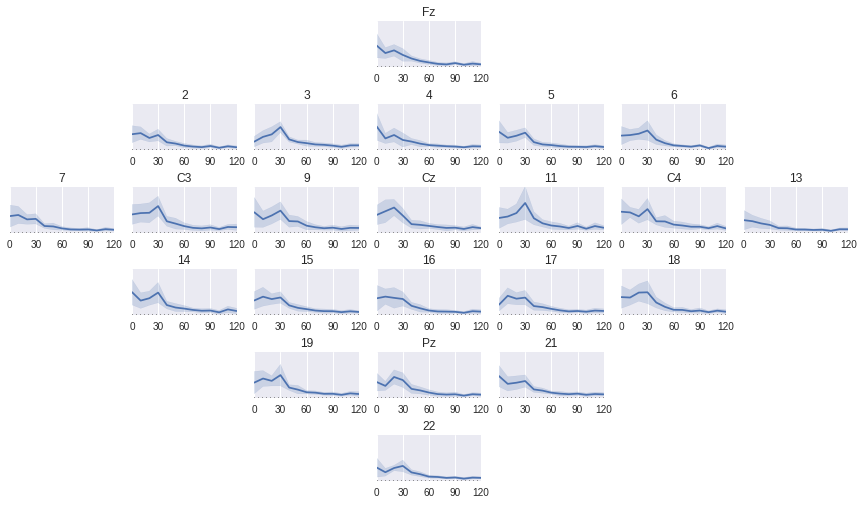

In [61]:
from braindecode.analysis.util import amplitudes_and_freqs
from braindecode.analysis.util import median_absolute_deviation
from braindecode.analysis.plot_util import plot_head_signals_tight_with_tube

bps, freqs = amplitudes_and_freqs(temp_spat_weights, sampling_rate=250.0,axis=2)

fig = plot_head_signals_tight_with_tube(np.median(bps, axis=0),
                                        median_absolute_deviation(bps, axis=0),
                              sensor_names, sensor_map=tight_bci_comp_4_2a_positions)
plt.xticks(range(bps.shape[2])[::3], np.round(freqs[::3]).astype(np.int32))

plt.tight_layout()
None

## Comparison to trialwise trained model

The trialwise trained model is significantly worse for this subject, only reaching  63.5%.
We see that this model seems to depend more on the lower frequencies around 10 Hz.

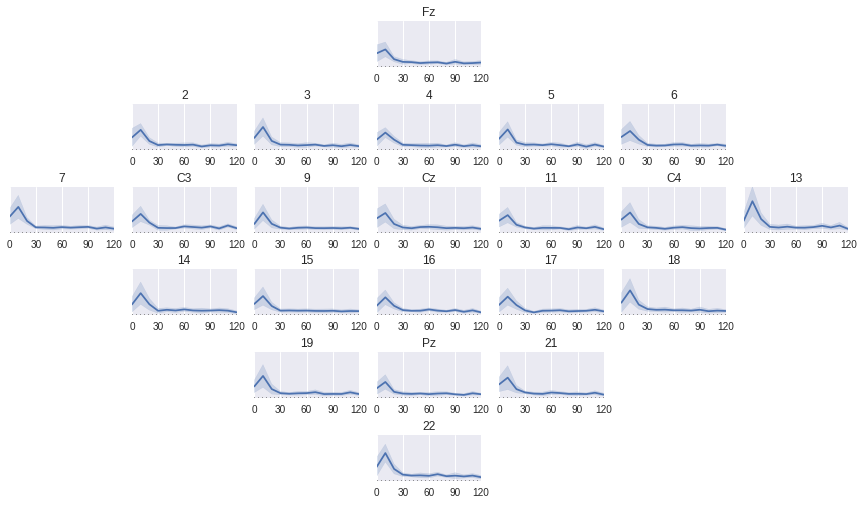

In [83]:
from braindecode.analysis.util import amplitudes_and_freqs
from braindecode.analysis.util import median_absolute_deviation
from braindecode.analysis.plot_util import plot_head_signals_tight_with_tube

bps, freqs = amplitudes_and_freqs(epo_temp_spat_weights, sampling_rate=250.0,axis=2)

fig = plot_head_signals_tight_with_tube(np.median(bps, axis=0),
                                        median_absolute_deviation(bps, axis=0),
                              sensor_names, sensor_map=tight_bci_comp_4_2a_positions)
plt.xticks(range(bps.shape[2])[::3], np.round(freqs[::3]).astype(np.int32))

plt.tight_layout()
None

### Open Possibilities

Cross-Subject comparisons, averages over all subjects etc.

## Heatmap

Basic idea is to propagate a relevance heatmap back to the input using both the weights and the activations to assign the relevance proportionally.

1. Start with a relevance map at some output of a layer,
    * easiest use the actual or predicted class label at the last layer as the given relevance
2. Propagate this relevance back layerwise to the input.
   * Relevance for a point in the feature map is always only redistributed to the input points that are connected to this output point (via a weight)
   * Relevance is redistributed among all points connected to this relevance, proportionally either to the relative squared strength of the connection (i.e. their weight) to the output or similarly weight * input (i.e. activation)
  
More details and theoretical motivation as deep taylor expansion here: [Explaining NonLinear Classification Decisions with Deep Taylor Decomposition](http://arxiv.org/abs/1512.02479)

* **clarity:** quite ok, basic meaning (what made classifier decide) is quite clear, in what kind of cases the procedure can be misleading less clear
* **information content:** good, timestructure visible that doesnt look random. Differences between sensors not so large :/
* **novelty:** maybe nice that there is a specific timestructure? But I guess this is known already for event-related-desynchronization?
* **correctness:** soso, I made quite some tests, however it is quite easy to make mistakes for me in the (up)convolutional redistribution as well as the uppooling redistribution. Also I have not yet included the biases.

I show the median relevance over all trials.

Sharp drops at the end are due to valid convolutions... Notice the bump near the end, which is not due to valid convolutions

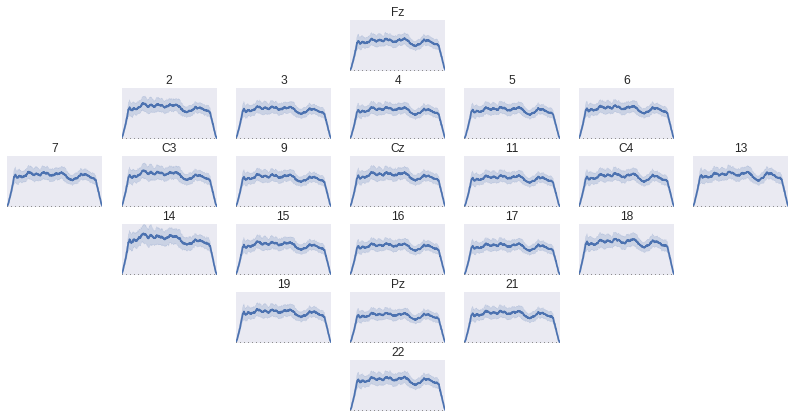

In [108]:
from braindecode.analysis.plot_util import plot_heatmap
plot_head_signals_tight_with_tube(median_relevance, mad_relevance,
    sensor_names,
    sensor_map=tight_bci_comp_4_2a_positions,
    figsize=(14,7))
None

### Classwise

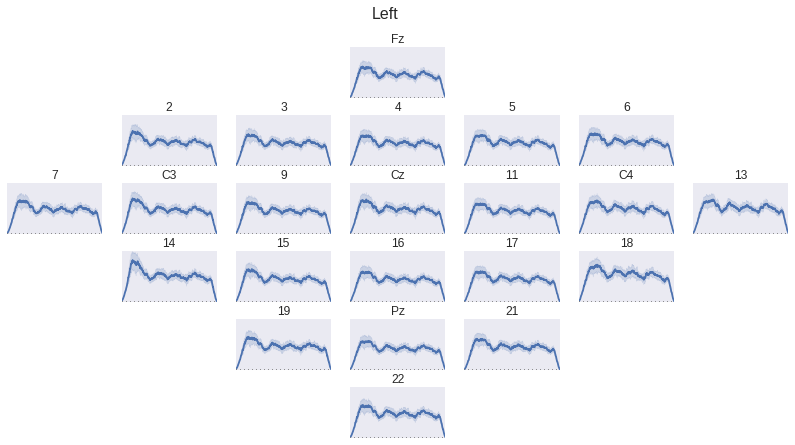

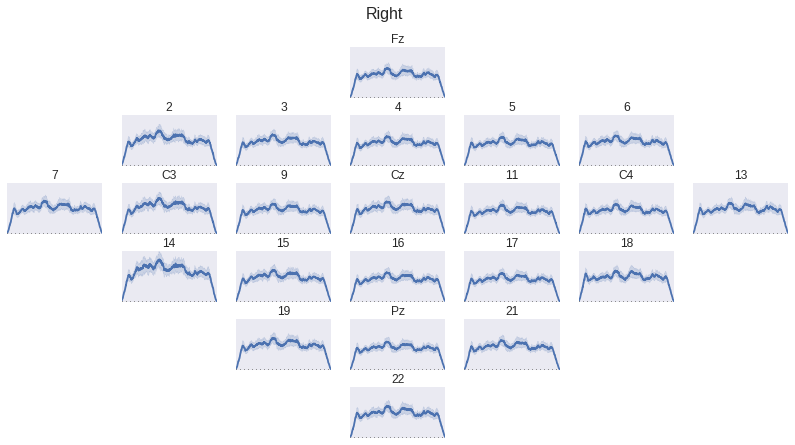

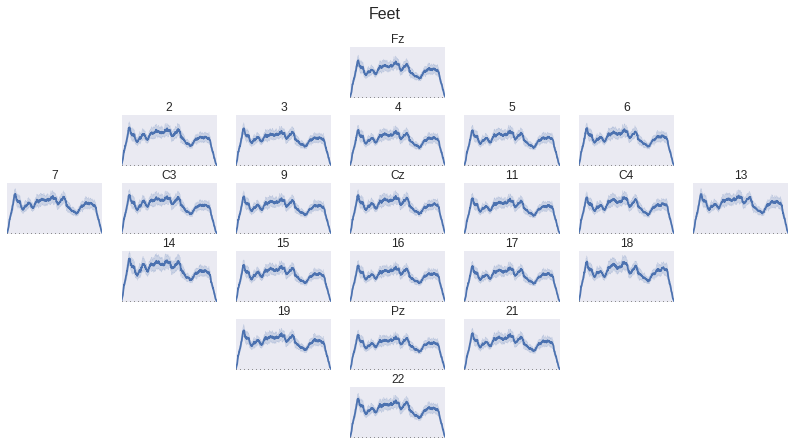

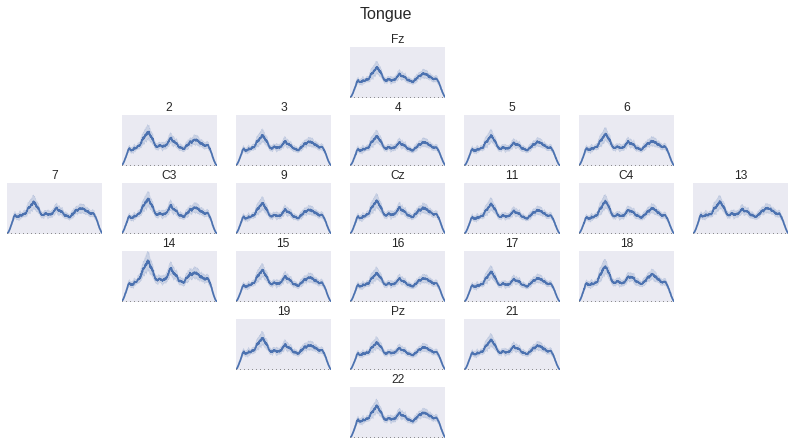

In [111]:
from braindecode.analysis.plot_util import plot_heatmap

class_names = ['Left', 'Right', 'Feet', 'Tongue']
for i_class in range(4):
    class_relevances = all_relevances[epo_ys[:, i_class] == 1]
    fig = plot_head_signals_tight_with_tube(np.median(class_relevances, axis=0), 
        median_absolute_deviation(class_relevances, axis=0),
        sensor_names,
        sensor_map=tight_bci_comp_4_2a_positions,
        figsize=(14,7))
    fig.suptitle(class_names[i_class], fontsize=16)
    #plt.tight_layout()
None

### Open Possibilities

* Looking at individual trials, for example misclassified trials to see why they were misclassified.
* Computing heatmaps for units of layer before,
* Also of cluster of units (could cluster activations pixelwise or correlate unit activations to find potential clusters, then compute heatmaps of those)


## Correlation with envelope

Correlating activations of units of pooling layer with envelope of input in different filterbands. Actually I use the moving sum of the envelope. The length of the sum window matches the number of samples a single activation of this unit is influenced by (i.e. the receptive field). 

* **clarity:** soso, basic idea very clear, but inteprreation difficult in case filterbands not well chosen or units not individually analyzable
* **information content:** soso?, not so much visible 
* **novelty:** nothing I am aware of (?)
* **correctness:** pretty ok, I tried to check for any indexing mistakes...

y Axis is frequency in Hz, x axis is units... so the x axis has no ordering or anything, simply the 40 units next to each other.

Filterbands are:

||
|-|
|**low** | 4| 8|16|34|64|104|
|**high**|8|16|34|64|104|125|

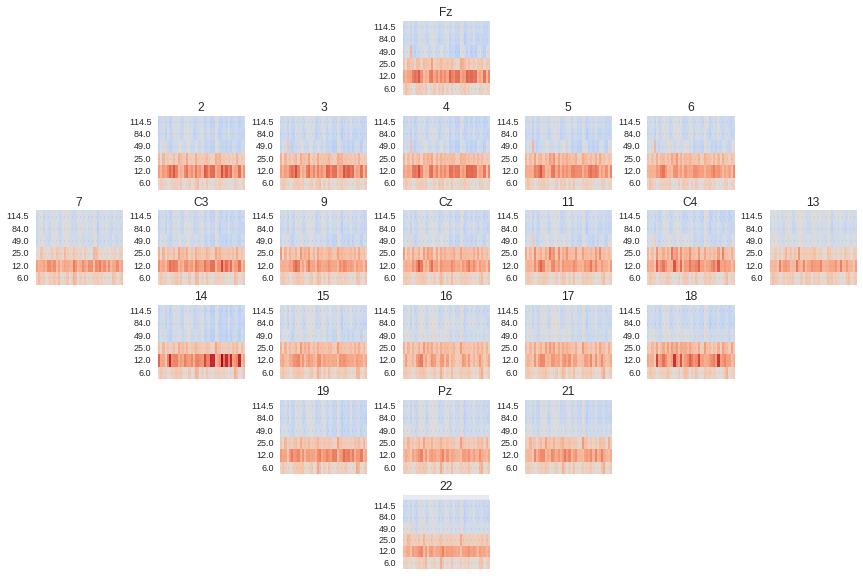

In [165]:
from braindecode.analysis.plot_util import plot_chan_matrices
fig = plot_chan_matrices(topo_corrs.transpose(1,2,0),
                        sensor_names, sensor_map=tight_bci_comp_4_2a_positions,
                  colormap=cm.coolwarm,  figsize=(12,8), vmin=-0.5, vmax=0.5)
plt.yticks(np.arange(7) + 0.5, np.mean(filterbands, axis=1))

for ax in fig.axes:
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
plt.tight_layout()
None

## Comparison to an untrained model with random weights

To see if any structure we see could be different from random, I ran the same analysis with a net with randomly initialized weights.

I scaled the correlations to have the same overall mean and overall variance as our net.
I think we can atleast see that our net mostly ignores the lowest bad (4-8 Hz) and the higher bands.

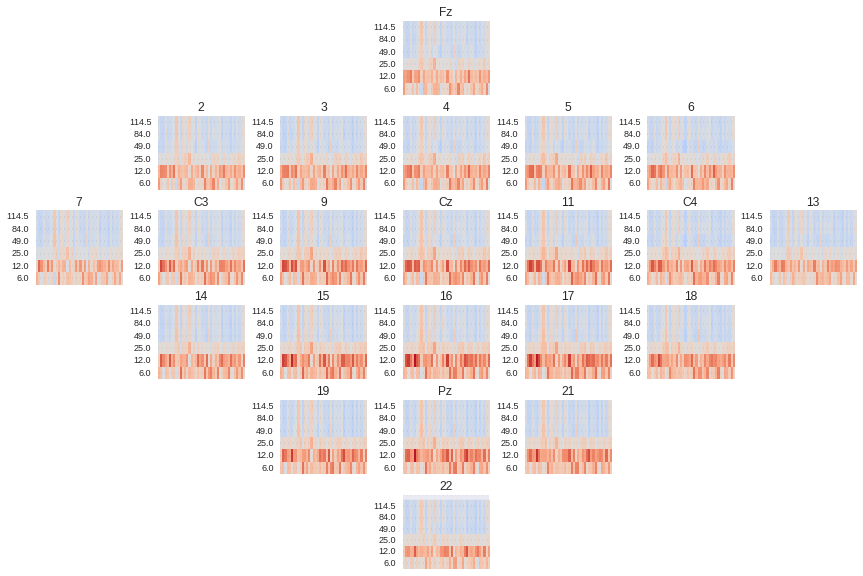

In [175]:
from braindecode.analysis.plot_util import plot_chan_matrices


fig = plot_chan_matrices(scaled_rand_topo_corr.transpose(1,2,0),
                        sensor_names, sensor_map=tight_bci_comp_4_2a_positions,
                  colormap=cm.coolwarm,  figsize=(12,8), vmin=-0.5, vmax=0.5)
plt.yticks(np.arange(7) + 0.5, np.mean(filterbands, axis=1))

for ax in fig.axes:
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
plt.tight_layout()
None

## Open Possibilities

* More finegrained frequencies

## Pattern reconstruction from first layer

* **clarity:** not superclear, should generate data  from activations of first layer
* **information content:** shows mostly fairly smooth oscillations are generated
* **novelty:** nothing I am aware of (?)
* **correctness:** soso, looked over this a lot, correlation between reconstruction and original is high (0.8), still looks quite weird I think....

These are windows of 500 ms, showing original signal and reconstruction from the activations of the temporal-spatial conv (the "separated" conv at the start). Blue is original, green reconstruction.

See some signals which seem to not even have been there before, otherwise more smooth, less noisy looking.


In [223]:
fig = plot_head_signals_tight(orig_and_reconstructed[0,:,125:250], sensor_names, 
                              sensor_map=tight_bci_comp_4_2a_positions,
                        figsize=(14,10))
movie_head_signals_tight(fig, orig_and_reconstructed[:20,:,125:250], "Orig + Reconstructed")

## Open possibilities 

* Reconstructions from deeper layer
* especialy if we train a model without pooling :) instead using stride.. then I wouldnt even have to care about inverting the pooling :)


## Strongest to weakest predicted windows

Showing those windows which were most and least strongly activated for a certain class.

* **clarity:** fairly clear
* **information content:** should be something but I don't see it ;)
* **novelty:** nothing I am aware of (?)
* **correctness:** should be correct, not much to do wrong here

Showing always the 5 best, then 7 trials inbetween , then 5 worst.

In [229]:
from IPython.display import display_html
class_names = ['Left', 'Right', 'Feet', 'Tongue']
for i_class in xrange(4):
    # always using last 10 samples
    class_preds = np.mean(all_outs_per_layer[-1][:,-10:,i_class], axis=1)

    best_to_worst_trials = np.argsort(class_preds)[::-1]

    best_trials = trial_ins[best_to_worst_trials[:5],:,-534:]

    worst_trials = trial_ins[best_to_worst_trials[-5:],:,-534:]
    between_trials =  trial_ins[best_to_worst_trials[6:-6:40],:,-534:]

    best_to_worst_topos = np.concatenate((best_trials, between_trials, worst_trials))

    sensor_names = get_bci_competition_iv_2a_sensors()
    fig = plot_head_signals_tight(best_to_worst_topos[0], sensor_names, 
                                  sensor_map=tight_bci_comp_4_2a_positions,
                            figsize=(14,10))
    mov = movie_head_signals_tight(fig, best_to_worst_topos, "Best to Worst ({:s}): ".format(
            class_names[i_class]))
    display_html(mov)

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAJTjltZGF0AAACrQYF//+p
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0NiByMjUzOCAxMjEzOTZjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxNSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTYg
bG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRl
cmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJf
cHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9
MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEgc2NlbmVjdXQ9NDAgaW50cmFfcmVm
cmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42
MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAK+Q
ZYiEABf//vfUt8yy7VNvtguo96KeJl9DdSUBm5bE7TqAAAADAFA//DcbYcwFCW2b+7XNG+Utbbu4
VSv0uHQJx9Wu+7olq82xGTsySfNSaicxBbIxgdAslH41EHWBLy0LZ5y8QQw0TqddfVc8J9Ihl8hO
0ZOzGlMyUvtqabO3Zcjo14CYo3oVZFS08V0b4XLO8oZvlsf4BFuEEH3FSnFfBSJYj+2xx+tDQU1H
H7eil5CWL3JVA29Dw6JXYaIkVYVEDAbgPu1js2uRFpyHlnY9EOK4JibrDLuKH+8DYZ7fO3LKZJWl
xqKRpLy+MFLoJVx/0l9W2DDKUCjAfFQHj3mrRthFSI10tMJ+YumQtCO0IfAbDB74DEk/24MTGj9/
sug0d4YHB+tdOxtOgWis/6NAymEJ82GeAREq45vjr9iHv4TSHEoWbVTu2hJDXTmX2Fn+VbmT/qdJ
TJFkkO0V/+1AV55uACshAAADAA7KDYjc0W92MKuAB3law095fZkysFcG4WJPhaB0K/+wWFMspAKd
fAIQM+24iZms++AgGfDFmpbJvmxrOu4E0xaDVSs29raUL/66UItDVuxmSus9Ztqta52Y/j4JtNB8
5WYoLtaxQMQMlGHc2OILppqDutzozya1T+MkEoEL2x2PHNyQMsK/+Br2GnqltcPN4QQgl9GLuvrw
Z8jjesgLm+QaclS6ncNgJ9+r4xn9q8ilD243qTRGYxqyOlcYKZtu/G6mzx+w343cXP26SX8MqMrf
kH7+zglRvNZPPvo86ngZo8xi0R9tS0M2DzncD3Rgxhc7F3MbqS5wTE4/KV7gV9uT8y867CMRSkI1
0MHkUcjfPhRQlQdH8SwdEHsmYJg7lVMNea5oml/7titnklqDCVXs1Ffvlbyr3w2UTvAQByTkQdWO
apl89xSuVhv8zwKcMB8zoflgOlM4oPUrl3OzR53irLaOdLR9Fc9dGv+lsPk5uZWClYbYl0sV5Vks
8TU3byLf5rU224rTiqHoVE5B/p/dfbjVVEwtJWjKKf3xQSvF9Zlr/n/CtEhXdc44DDE9U6A3o2wb
4V5d3oWYET3wTODdWKX71ywDT7DqoO4jh6FdB5I74lPvkDh7avB0Fjig+ZhmhzY3UpYRx18vPhWV
dmqk5fsrIv3jSrbCWWkZ11jqvw89Shriw8JNn2QC+UFvK3wW3r9nSImSdl9rnBjKZueFU4vVJX4g
8OsauAIUZRPmoipjR6FLREzqoqBpKqutjj0KeMnOtlOyDavbmuLh8GlMwFFHgpISCFB06xratrun
CXKUHoK8EWZUztetwGpMb5pOHzzlLIPVL6aA3X1Qr1LBxh1dp1EDNVuflsqqSoTVjfBwiDB9XD5Z
v3mKph8u15nW89BZQ9WXSxDV9qHa1S0KsgwHnAkkuKFBR+RlKqzoghQJXcFlPYJZyNznG7JhoeE7
RJ4BxSxO3C671TDbgZ/D4GatbPVYPsqHtxYge2XAk63Wwy+dWYenE4EzKXfOTkWL5VjSICDO4nSO
RYa8dtSbsZJjp8qjN/1KnVZsi3xB0op3aWSXx9O/wfOWccWlgv/eSM33evcZPUg/YLobIwje+Tyq
w8Ez9W0StQmOtnKIx4QF8kvDZRPycEet1q6DILJzf5Fyss190AEkrFjAkFfCdlFVjt4HM/c0GxLI
1XtUEyi7tS/nAaaMCP5zDI4UFUr88zysuMSU/HzTDfNKP/3v5wfW/9XAEX21o57TUwPQ0vjPVlF7
r25ujn0onZiyEf5bKAO1VcU127Te/A6cXhqmYKyhWii7kPBlJP6mL6HdKsEOqkQ3VEltEvI7zAiD
/J62ob2KB3l8jGgBxXyOS2cWN2Ad2c9MNro0LzqFp1MdvgUuoC7BHrHqH1KyKyz3l8EA0w09N9EQ
/SMJTuUPE0Fm3mzEQC5WKVGa/FWLBY5+9d/vkdSJ2exguZdLi4Fage0Gi8MDJ755GU0BlHGofBNo
jT4MbXoI7uAKvCGnpMjbZv7NRzWNM5yWuG22jfpVK3F6L7os7DH129GjSh4XgNbQUnp3EGZiUnZv
spKfDlXxf1x+/d9f4BMUug/uL/TdAaqE8uLncfSPIFotC6Pl/bBeGg2uM0tqGmwK0JJhGqJn2SrL
ALNbOuZpUea+fwGyqKiqljXf/cfxsulp5arIg4GIcVsBc1R1nUo0c5SaAMvr5qImDXix5AT7keoi
VHgN9RxNJPR+aMSZfsoAWMCQ1ACXE8DpAy+zgwyCm8u0q+SlSSg0/lcdKC3btsoDUHddiaS0R/R7
QWb0hrC9oV2ZNRaDigJzuF6fIHpT57+rqb9iZOSNlmMHOzUSkF2aK0CHKuXfMNLDq7kXVCIwBFdg
frEsFHOEJNQCiJ47sdyYF//jYHuPZozlPgBRfTO9a8HuFA1/7Aqnp7BDZhOMBFW6HU3XpJuaThcr
/NPBtkTtJZH6ohSOFUBzKMGHTWerh6IKkAykhuV+t6c23pyF8zQGxNAbEu9G39xD54oKFMfACMqR
VMxTG7LHKiPC9WE4OlJMhntZ0kX77JaDvPZNUhp06nNyYtTFzAObdfgdH/N+zAcpTbpkMhuBV/WT
+RS8d6LrFOrJjxC8yyUFXl6jLORl6F0DFn8HDuyYUEmOsCDAjtbJlMK6zbmnrgscbZnxPvyfxdxF
6mStvcAe5EuZ0DhpDW3E02noRtjBeZsb3yx/pgOuV/9h5UyzDSTGIrbfI/aI8Bzv5fSrQd21QMG6
jrJ3f/36sOJKN2f3C/3KjxrCD4A6rCenIcsc880DMiEo8zbpj9WRcGbXPo1tnnqTZmOS5VSmnGwd
IgvYjS3w0mCu4z5qrrAI4mnykzE7gNZBHqWCofZNeGeTUvJPZGjT8pOmo3uXdiS6e5wPI+HC7P2Q
CNSlfKGqtgN/P/n/DIZdvjZGrJhcTx6EYSoL

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAJRu9tZGF0AAACrQYF//+p
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0NiByMjUzOCAxMjEzOTZjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxNSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTYg
bG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRl
cmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJf
cHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9
MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEgc2NlbmVjdXQ9NDAgaW50cmFfcmVm
cmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42
MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAKtx
ZYiEABf//vfUt8yy7VNvtguo96KeJl9DdSUBm5bE7TqAAAADAFA//Gf6aOYBP7ZywlVa7ll9piE9
jD/zIqHlXZAB30S55HNgjdfO3H/vhfYZMk7rbHy15/c67xsa6W9gB0UZ9zfnOHgEG5OGY7zNycg1
ZZYxdo7oMxMSuQ1HTbw6STBuij6fDHZUWhjgtJgBnDk3h3MixOGRCVmeQPL2jnt7IuSdjuQqtsJr
cfCo4n4kbtnSO6fJj/dwBNbX9iMgTWjFMrYIr/33T/6WpHS1DD1oOfVB1mVnwbKH4fld/z61YCQd
I8DGNN+4AEpHlo0bo7oTV6giDcHgtJtpOKC/oIHRAZOW37wqw6E4bkc5/O9hg4KdkctboafJLReS
QuYeJ1EHSWWlLfb32b6n82F8R8ETzDSMd8X8jVv4/3vP5eQKbC1I8tAxZVva0xU8yyDCBsPreyeA
P0gnQXNrZZWVOxAf/G3+Sbmzj4R95dTmkOK0I7kV06UvBRLd4nmuuCNyuoWhGcvQe2X7i+ZglogA
AAMAr8Kf0hulPcf5nQAcUs7nalA4D+PmMRHOfcOr+UOSeNjh7nj9Vw/Sh+VpmUZtfsmX5vy1aHHu
oUIak0qASjKzAjuB6FUVoIHIpSbTybEm7s5v4mLHf6nkJsdE2gLRvAOKTysDF6gWzcPHnXlkhv0m
Hy1sFrGXnCQD1SyHrsG/pgd5nLFzycAPMhdSd+Lu9TyFpTsk/0+NLQEtRMKbZimd5Zev/fXwxPJt
j+3y4k/XipmFsf7ENM19GNbai9mnlWHXV0sSsVQAgmTvUCU8x3o4ywlZznm9fp2XQp0VWO1qgY+C
4mOw66Uhu7qjZR+YvMJjN+b7+E6ael1+xyTDHSajkD6DYCI+WxwydNjobQJiRM66PCkG0H9q2euJ
TscZrn5YNnzoB0GuKbBlzTVko4LCjC8DI/ZL6w1T1EJNg7RLoX4awf/jTiOdOn9BUGYNs5ud4JAa
z+CexDpHVi2tJKbj+lF4Zr0fc9I8kGCC3WArZENpIRtGiB/TC0I1GTBgh1lJYoyei6mETZ2usgjC
FRgkyto8k+OqjrVAuxN17rILeDdq6eUWn+lqYJ4S4Bx+V0iLxaUPppb0dE/EoihC6FV36cJuw5kU
J0KMt5cPisvscTa1sytTzHIVz+zdCzWy613VYtaJpPTXUusm0QBg2lTbplU/TZnSsu5peLpHNQj3
Quqj10jynmRra+opp2KeKoZvYCZ4+BovGlkUhQRqmkB+g5jo12i84W2Tj6T75dnKqw7DBMXKGk8s
S1U/Z95/s/8OQH0sZXHJAahI4qfQ62OFi4BuSWJQa8MIXh/AG6FiO5CZNjbvh2rHV6kKGnKafWqw
fAbQc2iWt4PSZi/Vg4dZNluP6iBfW6Szklbfi0R5FJS4/HIuoeu6naJZiCtp4Yq9U8F4QG30zn4i
aUzSvmZLn4+jdRw+OORcNsKiQrfP1wZ/X07tv2sjYyFk1FMzOPLSrwmaBwXwCBZ3AqIKyFaLM8x7
ZwitNi7NRjOfVqFCxqqmt0vsyWDufEVpSG7uqNtufOcz3FhYNIrYgBWSn8PBwc3PVGgP7+o7UXEg
32sDrQXYL1aibItJMsjteZ4cnsRPorp2b1vi5w7HG9o55xjyPZYPiHn69BwibjUk2umnzQNIbpKA
JzGK8qcgKf8M1xPDhtaa1pQzIqhKTSaG4XSXwPjBAr93qmB8qjJCojrP7yqPhCrsLvYwKQWgE0qg
DydAsUr20mbnGGznN+otxgIMGWzbRzU26Idp3bU4ZWv+FWeXSXxoblnhHExOYN6V3oMEhMVIXFmb
KLa91gKm7deh4OigmTOOzy5jqP3Ee5aJgBbMcL+Mv1M/HdVPvgOIeKtFuYUsCNJ/MLgzafKE9CHS
+Hsl+BLGlwZwD0SwaoKVbYcaH4eWwrxUIO7c0seZwXOpJO143rhHW/FbtpK/mfbnjYGSf5nqeGvR
jFpI4CdlbObATOjCKgVPgQzlnE8O+CaLkK8yeNBTRuYn29X+frEThThGHPrr47rvxU6i2jerfXBO
U7Rpw6zy8JI3WZm+ukcbHn45KNjulzbWssZaMBAeygwMbC4ZhMWOrpiY04t9c2ZhQy7R9Wg6fWa7
bQQHJj8A2s+TOgFF1RCznwbg3cVbcQr3wXzv4MndaOrn1qa23XY6/pe+risdYn5U89V3UOfNIkId
CmYSom8IWe5bcD4j/VZVwCm3Fv3BZWk8VvUv/1vSOJsP481cBEAOOL8Z+pfGR4QxVZkuDd/1CaLA
4pJifpP9FGeYpMzgAIdvwWkrUP5TcRjs6pRqzlUsu+DHRzDyvVgQ+ZLW8mjtzAgj4fkAs8sP3hNd
4asqRkYSdYGwzF3ypmWK5THdMtrqutqW2tyiT0uxddEAAe0B4J4oIKOFoXYETsHNPEeV8/iDlBlz
JHU0G7DOvMAvR2phweERRdRfiRnr9eBv7EhPw+y4oAZ2PtK0Aqgx51Q8UO1u/YmTkjZbiDsZ/E8T
oe5vwXeVrGotGXG2fLcBQyT3eeiCbDfs6vETqBlm3UBW34dk/s1V256Pj3s4Ci+md610vfcIQNV6
iXhiHApzK3FB1848RiwmCbgl8pRI9CzUtShyV2E+Ld8lbHB00EHJqbDPxCtJDWcRkReswOQGpFtH
D2ALFInq13OQ3jo9NOQACGnj1chel56msBEd7zbxxT/s9+u8cK4gCrvRZJHPnImK60RdZz4ma08U
XKEHSzluDGYjyQ7ezX3cD3SV7CvEKzr4bTncFp6XKkAkeTNsu8IeP4c6veKMY+Pa92Y0kbT7ObuI
uW7gMrHatJg0UIxtmsUSgG2vM3gJNo7n4n43Z/7eRnEDi76PnY5v+T/Vu6oOPTEhvIwDgrZG5pDu
aIOnLJmL+jWN5qV/Sur1kmDbbp1VreuRBydI

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAJQottZGF0AAACrQYF//+p
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0NiByMjUzOCAxMjEzOTZjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxNSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTYg
bG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRl
cmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJf
cHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9
MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEgc2NlbmVjdXQ9NDAgaW50cmFfcmVm
cmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42
MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAALRJ
ZYiEABf//vfUt8yy7VNvtguo96KeJl9DdSUBm5bE7TqAAAADAFA//GodtHMA25bRUCUE699LBKbi
PM7hGdh9Lu91OwyuV/cfnxbmUkHdCCfIsUm5gfiM2D8IhuqD2L6LfZReYqtoYkfEabEFQhZIgt1x
JESXiYouuoWYKjRW7F/nXuq8aJs/VQu1ZCQywg9bBEQ0QSw0tGI1GBAPeZLNRK96A8F5A2WgulGk
wNFfUVKuWiFQwFUhXroogWIK/WhKoq2FOSahwIR4EXG4lQQiK95DkJHMw/3fpzHkClRzNReUaz1O
JIiTOkQMeWcnBAccogDWr7XCxDx+tktEa67DP5YXTJzD2o9/zcCepJMuJyGm5Uqszt/+VO5vfdTI
IxN04vYwOOpLKmK2Ff0clONnGAWDZuGaJiiqoZ/PZdaS+rWPniZh1CCGbD++9CG14ra8tnqV6W9n
xD1mGdm2hyMQgAABoZMX4MSFfQF3vABr3XWQQLWw/q9JkC7ZI4lJ8R1GcZPtftiDyf6ElGiL4sHM
ULi1XB0x7Gh3+pZjAATRltayVgN3q3r5IEthNaZ/BozAOwMNn89W2srs5E7NYE+BlihqWUVy2G4h
gqwNvPTbakvf+PaYAkX2DWPEt25w2eoNj4pt3lZ9PLa5+jrgzePTRC0VUinlaxNjkTIgRrpR77ae
1bXhrsIWCH1ZnrZNZz3zbRgL5UTTM8auBN1vy0Iui+wJpxS9EChHgtBkVxrA2B2Bl8ouDgukQi2T
+n5FYyrTbKqPN3SG8hfyqg+rnWTBsEgcjs/6RYt7it7Aky3SmpSG2hbj56WcQGG7tP684V5FKz98
2aoPyctIxfxWAwraYiFQldtuZxRms24JarUenIL3jTrmbHwyxYmpv0R8b+dimI0+Pz6d/UEhwktf
MwEo6kVISVuABKOGNBv8FKJOroxDQlzZa2vwOCGBaU/ssXTaPIeGPpSAN84Si/uSGPJc4fddP733
3lu0fn68wGNYdr0QZC56KKXgufBdlU1FASJJg3Yy5p5JQhKOWnHZWcJF6dWX3/iOvgZkNSG3gEtz
3Y7svefsoaAfQSZV5+zrz5PO6b+H2Aljih3N9vSY5LQnHPprfBBBqbAul5ha01bFPQlNe3eyJfVk
vnpH3rD9apGqcfoj0rp0dOncCJqkTYlukYEM2NxyvHaaCrN62ZcMSwSjQiJ4RK8iq9/4tUUcrI2I
K475uqVuFVRrdzY7sEpxqa/jvgc3+tABhNg97ZT6szuN5U2zNsvMxZy+NvE/ANmBrK6lqRygnTdk
IW5cayIwR6sV3omYXIren0OX+6YiFWibK1PUsrdhHexE2T8SAdqkbsyGBy3lRvlcMGKs6aWYuDoe
gksg+KZK/nKBXvqRWtQC6+qxWtaq/WsINzWYfxZ7ewBklRe34Apk/1KOXz+G1wrIPw3J+q4NTZeP
uDrwJXc97mJ96gpb94chWTThhSuuflK+TrVUF0Hw6lHNZGkoGMLr2Fs7XTOeNIah/cFxEIHR3Fux
Kv4BOEFDSRYAqfDHgWUgABMp8YNrVK4a8xXKLqGeX2n8RhLJrZ06/GWPVi5WAwraYiFQldtsxa48
JFD2Od9LQBiPxl1Iv7FJu2Jqb9EfG/kV+CdmRYpXoeS/Wq4c/SbWgTh9d6FXJbZl1YErLCxXQpOb
jBH/MXCVus8WwgdGQbD+0E6uHu2T/Jl9ctZiDrmCsq1miy1+BPMusWRFsLbY0izzqGO3FD6wvwtz
4Pnf9L418/4Dhk9k2VsSP8ILgyN0KrMc5o7uhUKzImfwFfp11AuhQY+Dee2lRaEUCe4GjU+St42X
cSPPXmthuuCBupq4E7Bp98zYh4HuCrmCLW5dGww8fhifbcrbg+F3Fjal1rAhGoqSFT0zbr4/LVHy
1PAAPAgzrEQDowztRs918oNUjItRR9LNLMIkKcLAnISXMU/Nb2txAKQcaO4swi5Vh1IwC18koh24
49k82UmKPyJ1SW5Ij0JbWmICpuFzJtxFuUCoKj2mYtMSlcVaJ8Focl0dP/n6OxdyxnWWi5/d7WzD
RxeSm8hbtWRQXq1NH11nJjNI5i1RAe+3Y7vpacG1CsOfEtaZFz0/N3pScghBZGqary7u4DhJZaTn
zhwpc9xxeBnLqiqeSh/cnR/ZiEG8sWV9ULAIM9VlSXzHzVhLCEU7WjlD9p6DmPF4YchgVsZy22WN
K9j9ESlt4x/WvoaYzMV7MBPptNwsQ3DFAo4il8dO6/9m1bMg2s8tUtigjsXI66U/HvcC7lOzJeWf
HZOc8APcBCzoQEhAWMC4cUNX6hZvn0CjSpRppVhuFw/vkGsRKUKkS/r8t3fnvx7+TyqYJJCh1knQ
+5Xxmqx0MD5T3js3bO6m/YmTkjZXED5J5rCGqf/dIu8rWNRofXikoGIOQY3Fj48LKm/Z1znASNaH
Mepoxuf/Km5cr6BNXpZCG9hv1rpe3E0braaI0iAPJB85qjjCpZf50hDim4UvyBvrv04jugbVg80F
2vsvndaOp+V6J77GxMKtMbIRya/7xtvj4nvQ43St3MPhLjF4h3OQ3jo9Nb1AAbRwdeIKQXTV23rI
DSHAI7s2uMcQczQFHTBYJS2AX5uW/P3J13tdhLp6jptaQHsvs16hbatVqt2zdBK9K2jL4pENuXHL
+dCqi6ymiyvRf5xCWu6g+SZ1hJorFEEEf4p3zxJfiVSnWDmK314kLyYpDtpsznSNDkJLuLHB//He
z6LuNL6Sqesqrya62cV83l87OVTPeM1ykuaaNcC2lzKkmG+Z6Chu1aULpRfUOlApf7fFMebruL2h
0Ul0zTexIuweEduHVUbqwPO8tuQgZa0dQ0j1ESu8nY6p+2gFwAs2gt+PVEL3Wb2LQQfJ7u6drYjS
fNEL6/HMsdlY9OYKKhcgmkqlY96mbAt8bQi6

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAJdVttZGF0AAACrQYF//+p
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0NiByMjUzOCAxMjEzOTZjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxNSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTYg
bG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRl
cmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJf
cHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9
MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEgc2NlbmVjdXQ9NDAgaW50cmFfcmVm
cmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42
MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAALzp
ZYiEABf//vfUt8yy7VNvtguo96KeJl9DdSUBm5bE7TqAAAADAfQ/8HTi+ABtTEgU3ZZV2Xg30o9m
SD8ArZ8pUnYSMLLlb1yxlwMpL7IvUEbRqlNljFg4ovWaY4zoEbUVA7A85Ud2aZHtKC0jXP4DnG7H
lwicqdKmURPJjNomTksm0nD1vMxD1yaSEPgLQzX8UAU41+qEc/H5wcKXYNRg4WXRu4kOj6OZKXze
MAUK/KeepvW1jhkzxUxLIoBLBaHdXPJqEiCJvCUn1WwACVzNy++8PE4X6FAKwCN8zs5tlf+Vq8/N
024Y/H94OGuTeo4Il3NItcjMOYQVRmsrjf6BLLJqc1UQzyZ4cmSaFKchKs83H514W24P2wCndwK6
+mkp0nA9d7HgCAN2NwF3m7x8cVybIB+rhsaYZClxkt5nLouYFMUlYL8h4uavyvkgVF8UsWnPAAAD
AL/HQy82rrFCko4AfZ3SVf8aRloJz0IaLyZ60PDZh0BKFYNhtaGONqkWbdjFp+E3EjgGnBBP45F/
qEuMjUGYGqosCefMo4a4JxnDvenB1RVCiFaQkCRaCtJncIXGwrBFehvLDUyuLJeATu/dqO/iBCUo
UKbcuR15manc08/jX2TocCmMp2bGKspezAjr0MhvauWx6Bgq5v5bgMqn3IBCIcOuULv28K9uuELG
9vMhWuGjdOxWnP4PlRTGAKbN/jEeF0OHt7XRz1G/I/mso2KqxSSp0FZ+jvRNzOABh6OAbsBM90c9
D2jARe/f7aqKbsWInrMuCL2yxao+w22+U8Gr04rke3TN0d5n05iL55kl60Rft2IF2P6YW8ww9kw2
FjK5j5mVKAMzdqbqhCaRLWo+3MEYNuX45c+bVP5Lbdjr3xVcu2YxhNsn6oKbJ6G8UvXrD7KNOP5G
D++RgX7u33FgUMrYRL2DwakYHMj0l7ChvHhuXpFprxizX/uTtT/yqhcrgwQadaQ6qQLQMCKlCa1J
EHahqqKto0PwKsfsSJX8jhGsh+7taX+capBTR/XqEyFR18FBeqN75dmrLuYzSYU0c3imB4PqzBIb
Cmnk9Z9I8NhlgBowhKTQCn9SLDI8Dp8SwVYHIlTnVvjpKznumSDnOf20R1nsOD7pBqUcohlqYFYk
msvnpZJwl1zSdAY8cxF4o8+ZBs1pN1fois6QeN8LL2XA2T/qyEOsbTYzIPsqj5UFtVoo8ti/+KH0
I0iSZVvC9dWTtlRsTfdoHRX004hm4dIOtOd/sI38fiR4o+RX8bXnePTIluVFjHldSih/DyTjljrN
DAiEmbP19b5ohtsLpYu/nSu4YT8YAcL9d3SOn22cCDL1oz/En98FXLlUi1Y5PuOK6v/UKdWyG/gf
xqQ6CtQ6DPs4p9jymIUFWwaVjO7P4rsDENj7Skw5RxQpMaxyUmP7gsm8VrpTG5RDgRhAV/VWTFUT
hGcEjRY0eLoye3EWfV7aQku8aUh0bg/qDPaCuDd2Par3qiNK7ZtbkNEkNkPXFiIA10wn5GNVMY7m
xkD3W5cS/tnAYq1J34RyrnnmxAMT+6fghuvi/WYnL0qX2IXaYZik1pf3z+9JB0rwMKTraU5N8Nvj
E3saT5HWWfPZlsoK3qhLk1yiABbb2s9PhQU8kWvhsAJtbXXK2k1srHcmhYWBOOmJCeKjtLC1Xtrn
E0YseYIhyb4KVlpwlBhIOF+Q+hT1wWXsiHNVWv9dSrVo3fi981sEkVFgDaiV6zoFXM5oClO35A5a
Dmo8sh6eHFRsK3/IsKE22UyKM9eP57Ud0VPx65C8wy4V77GMDzu0y0KX0f3o2kpdeSHChO2d18St
n3T1Ayi53vgCljmyM17BlALp+RjPqnjq8pm9czCRjgQ/hOAIe/wClPJR6ivsufsWyKZKmn8QQEPd
6wpna702HO7anMMacT6sToSAt5UVddV2QaERK+ZR9ANbxRSV01DclW+nczMdMT8G/QVQzM+I09D/
J1SblepgfGo44/LFVzf0PQrTxbkW/AJVLmsd6ATv2yOijcuSO8gUyL61UF7VkY9EPDU1wqLfA0Fh
G+Cj9oJCTO2hju8uAWipVnXkrAKbT8syi2gTJzpCG465YtM8p29whpzz36epKnbvrl43Q50VqdRu
ib4JLx/09ye7UfWq12QGNoxtoZF2O5YG2K7lIyeV84l5s0bQMZtVb13/aYNy3fp2JCTJIxJOZ7Ks
NQpPbfvi6y1ayCuHNR5yc93/9+DHBK1mFVWxhp+LpHBxqTc4tYCSykiBiVoBP8yJf2r7ECjTHY35
J0eaRj0iTrBCh9LC9DI4XmTq3lFmE6hkW9LZRmkUjc4OSlYfm4GGarZvYM8R49PjTPa3KjYgk9Uz
gEwGhgb/JnIkc6Laasb0jwPSa01G+AVsUDoGSqUCAVTZzH1FSaQY56b9sjEw7nB7r7kNadfIhMYw
zyTusOnN6tVZPQdIwaXVumxT1wCRdOotmyU1oVZEbs8i8AMY4aVj0BcI8cJbU1ZUmnHaFB7XUbWv
k6mpHNZYDtgiCbZFM6jPs/1qIEM2wAvrJANrj01fj7ulEGIuL13jwAAENANueQJ2Tkou5B87K1s6
WsvQBxANfk6INqVjIc2h00TSKGWT9BspBP0YT81mA6PBw77FxbeQcfM1WOhgVXjvQdVm7qb9iZOS
Nj9hA8MaJtZX0VoEOVcu+WsxwIFnLqERgCK7A/WJYKOZ27XgIonkOGGeIs3gvibiVaj3s4Ci+md6
11vevvpb/V125PgNQdroFB1848RjHXalkmS3P/AURj85LPG1jA8C1EOwUQt20qiWdwH2kft80e0Z
F0O01Sayi02eriBoUxc2u5yG8dHpp1xQwFTS53A72kOV7jnn6VP81PghkmMf8L+ZRkLHQ+rZKMmJ
KySc1BfAp3FNMwLHVEjw8tklRcVSvEMxfz/L

# Code...


In [1]:
%%capture
import scikits.samplerate
import sklearn
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2
import logging
import theano.tensor as T
import lasagne
import logging
log = logging.getLogger()
log.setLevel("DEBUG")
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png' 

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = (16.0, 1.0)
matplotlib.rcParams['font.size'] = 7

In [46]:
from braindecode.scripts.print_results import ResultPrinter
#ResultPrinter('data/models/paper/bci-competition/cnt/shallow/').print_results()

In [63]:
from braindecode.experiments.load import load_model, load_model_epo_model_experiment_result
from braindecode.veganlasagne.layers import (get_n_sample_preds,
    get_input_shape, get_used_input_length, get_input_var,
    transform_to_normal_net, get_model_input_window)
import numpy as np
from pylearn2.config import yaml_parse

basename = 'data/models/paper/bci-competition/cnt/shallow/10'
model, _, exp, result =  load_model_epo_model_experiment_result(basename)
all_layers = lasagne.layers.get_all_layers(model)

INFO:braindecode.experiments.experiment_runner:Setting n_sample preds automatically to 467
INFO:braindecode.experiments.experiment_runner:Input window length is 534


In [64]:
exp.dataset.load()

INFO:braindecode.datasets.combined:Load Training Set...
INFO:braindecode.datasets.combined:Load Test Set...
INFO:braindecode.mywyrm.clean:Clean Training Set...
INFO:braindecode.mywyrm.clean:Rejected channels: []
INFO:braindecode.mywyrm.clean:#Clean trials:     288
INFO:braindecode.mywyrm.clean:#Rejected trials:  0
INFO:braindecode.mywyrm.clean:Fraction Clean:    100.0%
INFO:braindecode.mywyrm.clean:(from maxmin):     0
INFO:braindecode.mywyrm.clean:(from var):        0
INFO:braindecode.mywyrm.clean:Clean Test Set...
INFO:braindecode.mywyrm.clean:Rejected channels: []
INFO:braindecode.mywyrm.clean:#Clean trials:     288
INFO:braindecode.mywyrm.clean:#Rejected trials:  0
INFO:braindecode.mywyrm.clean:Fraction Clean:    100.0%
INFO:braindecode.mywyrm.clean:(from maxmin):     0
INFO:braindecode.mywyrm.clean:(from var):        0
INFO:braindecode.mywyrm.clean:Create Cleaned Cnt Sets...
INFO:braindecode.datasets.combined:Create sets from cleaned cnt...
INFO:braindecode.datasets.cnt_signal_mat

### Weights

In [ ]:
ResultPrinter('data/models/paper/bci-competition/epo/shallow/').print_results(
    params=dict(layers='$cnt_shallow_square', pool_type='Pool2DLayer'))

In [59]:
from braindecode.analysis.combine_weights import combine_temporal_spatial_weights

temp_weights = all_layers[2].W.get_value()
spat_weights = all_layers[3].W.get_value()
temp_spat_weights = combine_temporal_spatial_weights(temp_weights, spat_weights)

In [90]:
from braindecode.analysis.combine_weights import combine_temporal_spatial_weights
epo_basename = 'data/models/paper/bci-competition/epo/shallow/38'
epo_model, _, epo_exp, epo_result = load_model_epo_model_experiment_result(epo_basename)

epo_layers = lasagne.layers.get_all_layers(epo_model)
epo_temp_spat_weights = combine_temporal_spatial_weights(epo_layers[2].W.get_value(), epo_layers[3].W.get_value())
assert (epo_exp.dataset.train_set.signal_processor.set_loader.filename ==
        exp.dataset.train_set.signal_processor.set_loader.filename)

## Heatmap

In [ ]:
epo_exp.dataset.load()

In [94]:
from braindecode.analysis.heatmap import create_heatmap_fn
from braindecode.veganlasagne.layers import create_pred_fn

epo_train_set = epo_exp.dataset.sets[0]
epo_iterator = epo_exp.iterator
epo_topo = epo_train_set.get_topological_view()
epo_ys = sklearn.preprocessing.OneHotEncoder(4, 
         sparse=False).fit_transform(epo_train_set.y[:,np.newaxis])

heatmap_fn = create_heatmap_fn(epo_layers,rules=['z_b', 'adapt_z_b'], return_all=False,
                              min_in=np.min(epo_topo),
                              max_in=np.max(epo_topo))

epo_pred_fn = create_pred_fn(epo_model)

In [96]:
all_relevances = []
for i_trial in xrange(len(epo_topo)):
    trial_topo = epo_topo[i_trial:i_trial+1]
    
    pred = epo_pred_fn(trial_topo)[0]
    # only take correct part of prediction
    pred = pred * epo_ys[i_trial]
    trial_relevances = heatmap_fn(pred.astype(np.float32),
        trial_topo[0])
    all_relevances.append(trial_relevances)
all_relevances = np.array(all_relevances)


median_relevance = np.median(all_relevances, axis=0).squeeze()
mad_relevance = median_absolute_deviation(all_relevances, axis=0).squeeze()

## Envelope

## Compute all outs per layer

In [117]:
import theano
from braindecode.veganlasagne.layers import create_pred_fn
from braindecode.veganlasagne.layers import get_input_time_length, get_n_sample_preds
train_set = exp.dataset.sets[0]

all_out_fn = create_pred_fn(all_layers)

iterator = exp.iterator
iterator.input_time_length = get_input_time_length(model)
iterator.n_sample_preds = get_n_sample_preds(model)



In [118]:
all_outs_per_batch = [all_out_fn(batch[0]) for batch in iterator.get_batches(train_set, False)]
batch_sizes = [len(batch[0]) for batch in iterator.get_batches(train_set, False)]
all_outs_per_batch = np.array(all_outs_per_batch)
all_outs_per_layer = [np.reshape(np.concatenate(out_l), ((len(out_l),) + out_l[0].shape)) 
                      for out_l in all_outs_per_batch.T]

del all_outs_per_batch

In [119]:
np.diff(np.flatnonzero(np.diff(np.max(train_set.y, axis=1)) != 0))[:20]
# -> trial len is 749 in our cut

array([ 749, 1254,  749, 1169,  749, 1203,  749, 1259,  749, 1362,  749,
       1168,  749, 1301,  749, 1182,  749, 1249,  749, 1157])

In [159]:
#Layer 5 is  Pool layer.. 7 is after log
from braindecode.datasets.pylearn import DenseDesignMatrixWrapper

from braindecode.analysis.kaggle import (transform_to_time_activations,
                                         transform_to_cnt_activations,
                                        transform_to_trial_acts)
#trial_acts_l5 = transform_to_trial_acts(all_outs_per_layer[5], batch_sizes, iterator.n_sample_preds,
#                                       n_trial_len=749)
trial_acts_l7 = transform_to_trial_acts(all_outs_per_layer[7], batch_sizes, iterator.n_sample_preds,
                                       n_trial_len=749)

### Compute envelopes

In [150]:
from braindecode.analysis.util import (lowpass_topo,
                                       highpass_topo,
                                       bandpass_topo)


from scipy.signal import hilbert

from copy import deepcopy

# Compute envelope as sum over last 100 samples' envelope
# Make iterator which extracts full trials + 99 samples at start
dummy_iterator = deepcopy(exp.iterator)

dummy_iterator.n_sample_preds = 749 # length of trial
dummy_iterator.input_time_length = 749 + 99 # add 99 to have all the pooling region covered
# (75 pool size + (25 -1) from kernel size of first layer)


train_topo = train_set.get_topological_view()
filterbands = [[4.0,8.0],[8.0,16.0],[16.0,34.0],[34.0,64.0], 
               [64.0,104.0],[104.0,125.0]]
env_per_filterband = []
for low_cut_hz, high_cut_hz in filterbands:
    if low_cut_hz > 0 and high_cut_hz < 125:
        filtered = bandpass_topo(train_topo, low_cut_hz, 
                                 high_cut_hz, sampling_rate=250.0, axis=0, filt_order=4)
    elif low_cut_hz == 0:
        filtered = lowpass_topo(train_topo, high_cut_hz, 
                            sampling_rate=250.0, axis=0, filt_order=4)
    elif high_cut_hz == 125:
        filtered = highpass_topo(train_topo, low_cut_hz, 
                            sampling_rate=250.0, axis=0, filt_order=4)
    filt_set = DenseDesignMatrixWrapper(topo_view=filtered,y=train_set.y,axes=train_set.axes)
    
    trial_batches = [b[0] for b in dummy_iterator.get_batches(filt_set, shuffle=False)]
    trial_batches = np.array(trial_batches)[:,0,:,:,:]
    env = np.abs(scipy.signal.hilbert(trial_batches, axis=2))
    summed_env = np.ones(env.shape[0:2] + (749,)) * np.nan
    for i_trial in xrange(env.shape[0]):
        for i_chan in xrange(env.shape[1]):
            summed_env[i_trial, i_chan] = np.convolve(env[i_trial,i_chan,:,0], [1] * 100, 
                                                      mode='valid')
    assert not np.any(np.isnan(summed_env))
    env_per_filterband.append(summed_env)

env_per_filterband = np.array(env_per_filterband)

In [171]:
env_for_cov = env_per_filterband.transpose(0,2,1,3).reshape(
    env_per_filterband.shape[0] * env_per_filterband.shape[2], # filterbands * sensors
    env_per_filterband.shape[1] * env_per_filterband.shape[3]) # trials * samples
acts_for_cov = trial_acts_l7.swapaxes(0,1).reshape(trial_acts_l7.shape[1],-1) # units x (trials * samples)


corrcoeff = np.corrcoef(env_for_cov, acts_for_cov)

relevant_corrs = corrcoeff[:132,132:]

topo_corrs = relevant_corrs.reshape(env_per_filterband.shape[0], #filterbands
                              env_per_filterband.shape[2],#n_sensor_names
                              trial_acts_l5.shape[1]) #n_units

### compute for random model

In [166]:
random_model = deepcopy(all_layers)
all_rand_params = lasagne.layers.get_all_params(random_model)

from numpy.random import RandomState
rng = RandomState(3932487)

[p.set_value(rng.randn(*p.get_value().shape).astype(np.float32) * np.std(p.get_value()) + np.mean(p.get_value())) 
     for p in all_rand_params]

[None, None, None, None, None, None, None, None, None, None]

In [167]:
all_rand_layers = lasagne.layers.get_all_layers(random_model)
rand_out_fn = create_pred_fn(all_rand_layers)

In [168]:
rand_outs_per_batch = [rand_out_fn(batch[0]) for batch in iterator.get_batches(train_set, False)]
batch_sizes = [len(batch[0]) for batch in iterator.get_batches(train_set, False)]
rand_outs_per_batch = np.array(rand_outs_per_batch)
rand_outs_per_layer = [np.reshape(np.concatenate(out_l), ((len(out_l),) + out_l[0].shape)) 
                      for out_l in rand_outs_per_batch.T]
del rand_outs_per_batch

In [169]:
rand_trial_acts_l7 = transform_to_trial_acts(rand_outs_per_layer[7], batch_sizes, iterator.n_sample_preds,
                                       n_trial_len=749)

In [173]:
rand_acts_for_cov = rand_trial_acts_l7.swapaxes(0,1).reshape(
    rand_trial_acts_l7.shape[1],-1) # units x (trials * samples)


rand_corrcoeff = np.corrcoef(env_for_cov, rand_acts_for_cov)

rand_relevant_corrs = rand_corrcoeff[:132,132:]

rand_topo_corrs = rand_relevant_corrs.reshape(env_per_filterband.shape[0],
                              env_per_filterband.shape[2],#n_sensor_names
                              rand_trial_acts_l7.shape[1]) #n_units

scaled_rand_topo_corr = rand_topo_corrs  - np.mean(rand_topo_corrs)# center mean
# give same standard deviation
scaled_rand_topo_corr = scaled_rand_topo_corr * np.std(topo_corrs) / np.std(scaled_rand_topo_corr) 
# give same mean
scaled_rand_topo_corr = scaled_rand_topo_corr + np.mean(topo_corrs)

## Patterns stuffs

TODO: split out biases before computing patterns...

In [176]:
from braindecode.veganlasagne.layers import split_out_biases, split_out_nonlinearities

In [183]:
trial_ins = transform_to_trial_acts(all_outs_per_layer[0],batch_sizes, iterator.n_sample_preds,
                                   n_trial_len=749)

In [186]:

from braindecode.analysis.combine_weights import transform_to_combined_weights
combined_model = transform_to_combined_weights(model,i_temp_layer=2)
combined_layers = lasagne.layers.get_all_layers(combined_model)

In [187]:
bias_splitted_model = split_out_biases(combined_model)
bias_splitted_layers = lasagne.layers.get_all_layers(bias_splitted_model)

In [191]:
pred_fn = create_pred_fn(bias_splitted_layers[1])

In [200]:
bias_splitted_out_l_1.shape

(288, 2, 40, 976, 1)

In [201]:
bias_splitted_out_l_1 = np.array([pred_fn(batch[0]) for batch in iterator.get_batches(train_set, False)])

In [203]:
trial_acts_l_1 = transform_to_trial_acts(bias_splitted_out_l_1, batch_sizes, iterator.n_sample_preds,
                       n_trial_len=749)

In [205]:
%%time
from braindecode.analysis.patterns import transform_conv_weights_to_patterns

# do not flip filters as combine weights already flips filters...
patterns = transform_conv_weights_to_patterns(temp_spat_weights, trial_ins[:,:,:,np.newaxis],
                                  trial_acts_l_1[:,:,:,np.newaxis], flip_filters=False)

CPU times: user 5.65 s, sys: 164 ms, total: 5.81 s
Wall time: 5.82 s


In [206]:
scaled_patterns = patterns * np.std(temp_spat_weights) / np.std(patterns)
weights_patterns = np.array([temp_spat_weights, scaled_patterns]).transpose(1,2,3,0)

In [207]:
from braindecode.analysis.plot_util import plot_head_signals_tight
from braindecode.datasets.sensor_positions import (tight_bci_comp_4_2a_positions,
                                                   get_bci_competition_iv_2a_sensors)
from braindecode.analysis.movie_util import movie_head_signals_tight

sensor_names = get_bci_competition_iv_2a_sensors()
fig = plot_head_signals_tight(weights_patterns[0], sensor_names, 
                              sensor_map=tight_bci_comp_4_2a_positions,
                        figsize=(14,10))
movie_head_signals_tight(fig, weights_patterns, "Weights + Patterns")

In [208]:
from braindecode.analysis.patterns import create_pattern_reconstruct_fn
from braindecode.analysis.combine_weights import transform_to_combined_weights

#combined_model = transform_to_combined_weights(normal_net, i_temp_layer=2)
#all_combined = lasagne.layers.get_all_layers(combined_model)

In [210]:
from braindecode.veganlasagne.layers import transform_to_normal_net

In [212]:
epo_net = transform_to_normal_net(bias_splitted_model)
epo_splitted_layers = lasagne.layers.get_all_layers(epo_net)

In [214]:
reconstruct_fn = create_pattern_reconstruct_fn(epo_splitted_layers[:2],
                                               [patterns[:,:,:,np.newaxis]], 
                                               patterns_flipped=False,
                                               return_all=True)

print ("with patterns", np.corrcoef(reconstruct_fn(trial_ins[:,:,-534:,np.newaxis])[0].flatten(),
       trial_ins[:,:,-534:,np.newaxis].flatten()))

reconstruct_fn = create_pattern_reconstruct_fn(epo_splitted_layers[:2],
                                               [temp_spat_weights[:,:,:,np.newaxis]], 
                                               patterns_flipped=False,
                                               return_all=True)

print ("With weights", np.corrcoef(reconstruct_fn(trial_ins[:,:,-534:,np.newaxis])[0].flatten(),
       trial_ins[:,:,-534:,np.newaxis].flatten()))

('with patterns', array([[ 1.        ,  0.80764196],
       [ 0.80764196,  1.        ]]))
('With weights', array([[ 1.        ,  0.09460953],
       [ 0.09460953,  1.        ]]))


In [215]:
reconstructed_trials = reconstruct_fn(trial_ins[:,:,-534:,np.newaxis])[0]

In [216]:
orig_and_reconstructed = np.array([trial_ins[:,:,-534:], reconstructed_trials[:,:,:,0]]).transpose(1,2,3,0)


## Gradient Ascent

In [355]:
from braindecode.analysis.input_gradient import create_descent_function
without_softmax = deepcopy(model)
without_softmax.nonlinearity = lambda x: x
#rand_in_var, update_fn  = create_descent_function(without_softmax, [[100,-1,-1,-1]] * 467)

rand_in_var, update_fn  = create_descent_function(without_softmax, [[-1,100,-1,-1]] * 467)

In [358]:
n_epochs = 3000
for i_epoch in xrange(n_epochs):
    cost = update_fn()
    if i_epoch % (n_epochs  // 5) == 0:
        print cost

636.332211213
641.146157846
628.369907666
626.772479483
618.024615971


In [293]:
from scikits.samplerate import resample

In [359]:
bps, freqs = amplitudes_and_freqs(rand_in_var.get_value()[0], axis=1, sampling_rate=250.0)
smoothed_bps = resample(bps.squeeze().T, 0.1, type='linear').T
smoothed_freqs = resample(freqs, 0.1, type='linear')


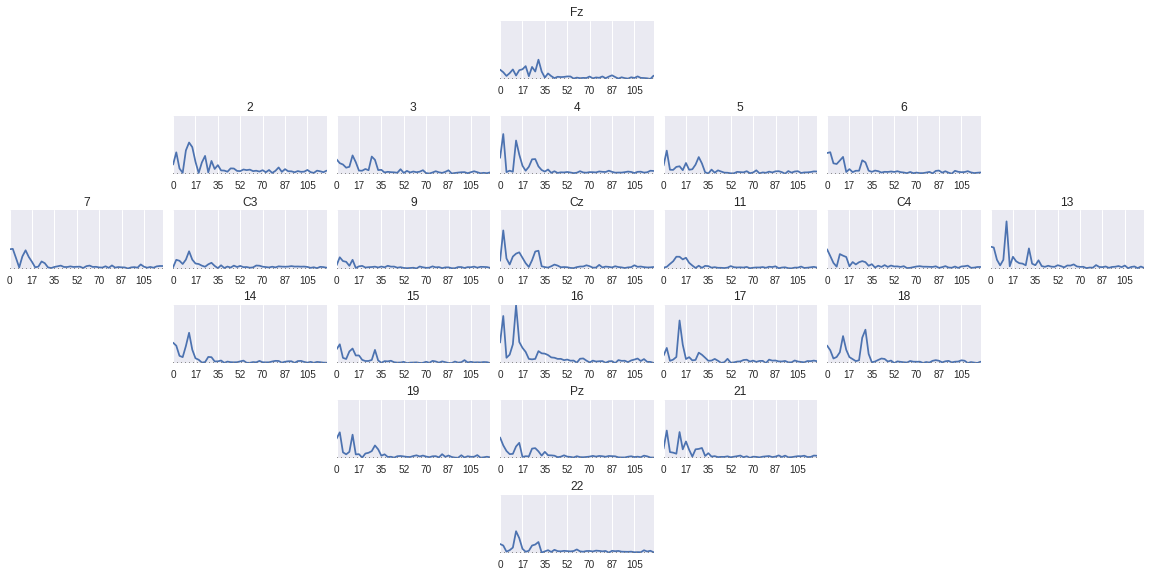

In [360]:
plot_head_signals_tight(smoothed_bps, sensor_names, sensor_map=tight_bci_comp_4_2a_positions,
                       figsize=(16,8))

plt.xticks(range(smoothed_bps.shape[1])[::7], np.round(smoothed_freqs[::7]).astype(np.int32))

plt.tight_layout()
None

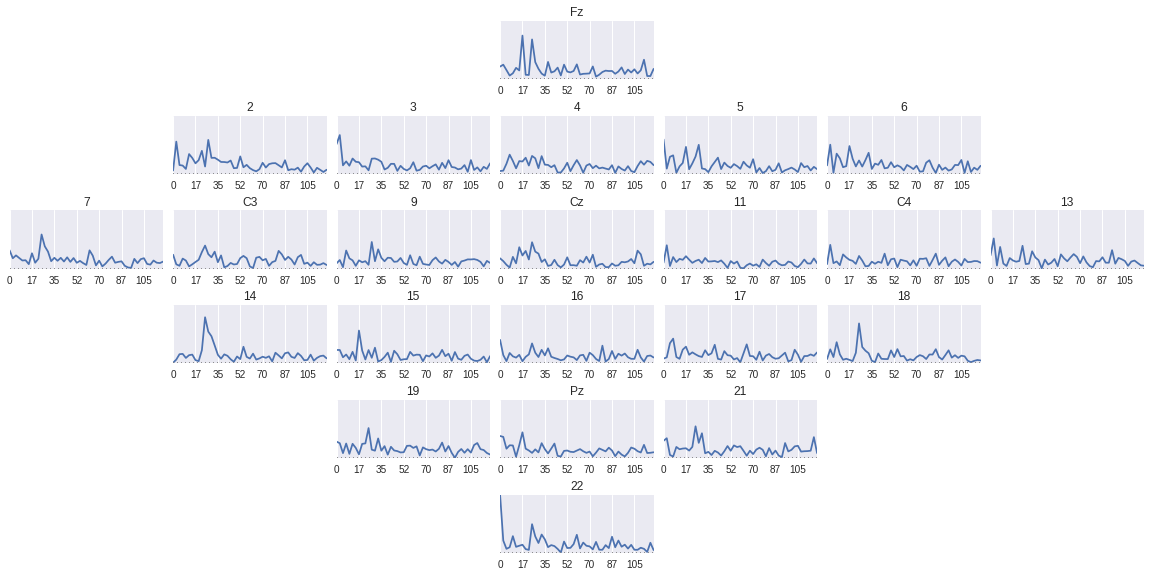

In [347]:
plot_head_signals_tight(smoothed_bps, sensor_names, sensor_map=tight_bci_comp_4_2a_positions,
                       figsize=(16,8))

plt.xticks(range(smoothed_bps.shape[1])[::7], np.round(smoothed_freqs[::7]).astype(np.int32))

plt.tight_layout()
None

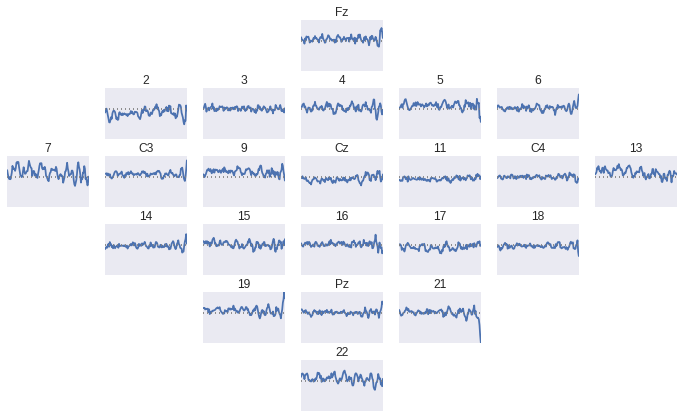

In [348]:
plot_head_signals_tight(rand_in_var.get_value()[0,:,-125:], sensor_names, sensor_map=tight_bci_comp_4_2a_positions)
None

## Transforming Net

In [232]:
inputs = all_outs_per_layer[0]

In [448]:
import theano.tensor as T
wanted_activation = np.array([[1,0,0,0]] * (467 * 2), dtype=np.int32)
n_trials = 2

in_shape = get_input_shape(model)

sensor_weights = theano.shared(np.ones((n_trials,22), dtype=np.float32) * 0.5)

in_shape = [n_trials] + list(in_shape[1:])

rng = RandomState(35445)
rand_input = rng.randn(*in_shape).astype(np.float32)
rand_in_var = theano.shared(rand_input)

weighted_in = rand_in_var * sensor_weights.dimshuffle(0,1,'x','x')

# have to supply input_var extra in case of final reshape layer
output = lasagne.layers.get_output(model, deterministic=True, 
    inputs=weighted_in, input_var=weighted_in)

output_cost = lasagne.objectives.categorical_crossentropy(output, wanted_activation)

cost = output_cost.mean()

learning_rate = 0.01
updates = lasagne.updates.adam(cost, [sensor_weights], learning_rate=learning_rate)
updated_sensor_W = updates[sensor_weights]

updated_sensor_W = T.clip(updated_sensor_W, 0,2)
updated_sensor_W = updated_sensor_W / T.mean(updated_sensor_W)
updates[sensor_weights] = updated_sensor_W

update_fn = theano.function([], cost, updates=updates)



In [399]:
epo_ys[:10]

array([[ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.]])

In [449]:
rand_in_var.set_value(all_outs_per_layer[0][3])

In [450]:
n_epochs = 3000
for i_epoch in xrange(n_epochs):
    cost = update_fn()
    if i_epoch % (n_epochs  // 5) == 0:
        print cost

0.0146566080353
0.000353501420503
0.000196427963648
0.000133849491393
0.000130447341372


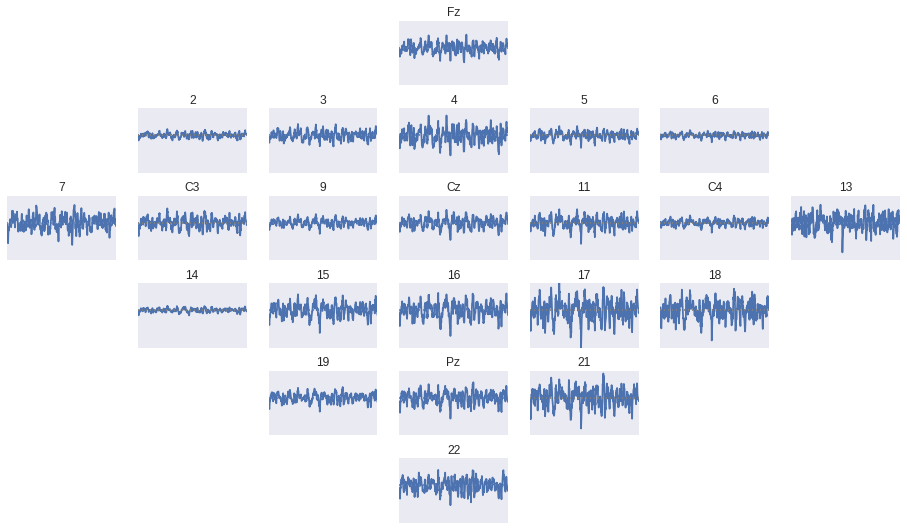

In [446]:
plot_head_signals_tight(weighted_in.eval()[1,:,-500:], sensor_names, sensor_map=tight_bci_comp_4_2a_positions,
                       figsize=(16,9))
None

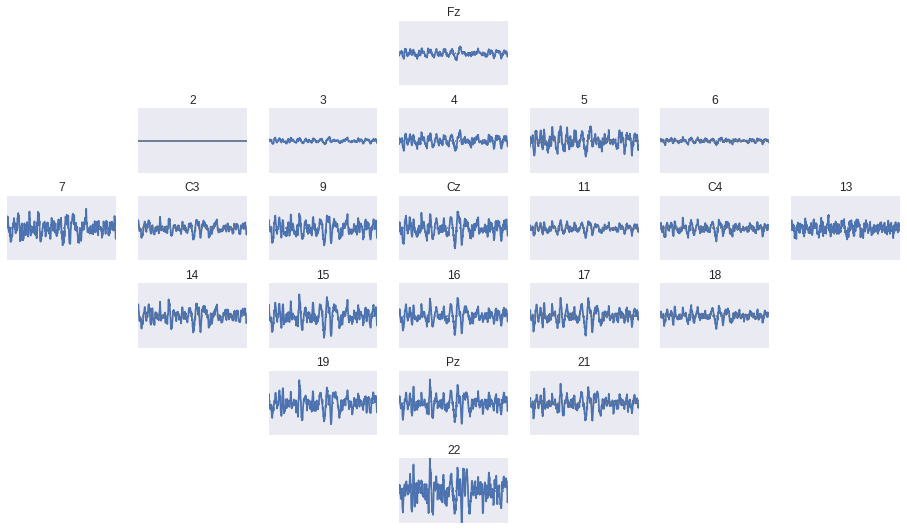

In [451]:
plot_head_signals_tight(weighted_in.eval()[1,:,-500:], sensor_names, sensor_map=tight_bci_comp_4_2a_positions,
                       figsize=(16,9))
None

In [388]:
sensor_weights.get_value()

array([ 1.10773063,  2.01231551,  2.01231551,  2.01231551,  2.01231551,
        0.38960612,  0.        ,  2.01231551,  0.        ,  0.        ,
        0.33949175,  0.        ,  2.01231551,  0.        ,  2.01231551,
        1.85406947,  2.01231551,  0.19825886,  0.        ,  0.        ,
        0.        ,  2.01231551], dtype=float32)